# Self Calibration simulation
code by Louise, using JC code and a note by Creidhe. 

This notebook gives the power on the detector array :
- for different positions of the calibration source (azimuth, elevation) 
- for different configurations of the horn array

It also contains the demonstration of the expression that gives the power of one baseline from powers of configurations that can be measured experimentally. Be carefull, the expression in the paper https://arxiv.org/pdf/1209.4905.pdf is wrong.   

In [3]:
import numpy as np
import copy

%matplotlib notebook
#%matplotlib inline
from matplotlib.pyplot import *
rc('figure',figsize=(10,7))
rc('font',size=12)
rc('text',usetex=False)


import qubic

Get the directory of the dictionary : 

In [4]:
basedir = '/home/mousset/GitQUBIC'
dictfilename = basedir + '/qubic/qubic/scripts/global_source.dict'

d = qubic.qubicdict.qubicDict()
d.read_from_file(dictfilename)

IOError: [Errno 2] No such file or directory: '/home/mousset/GitQUBIC/qubic/qubic/scripts/global_source.dict'

Create a QUBIC Multiband Instrument and a scene : 

In [4]:
q = qubic.QubicMultibandInstrument(d)

s = qubic.QubicScene(d)


Create a function that gives the power on the focal plane for an instrument q, and a source at a given position with respect to the instrument.

In [5]:
def get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance):
    """
    Compute power on the focal plane for different positions of the source
    with respect to the instrument.

    Parameters
    ----------
    q : a qubic monochromatic instrument
    nn : int
        Pixel number on one side on the focal plane image
    xmin : float
    xmax : float
    theta : array-like
        The source zenith angle [rad].
    phi : array-like
        The source azimuthal angle [rad].
    spectral_irradiance : array-like
        The source spectral_irradiance [W/m^2/Hz].

    Returns
    ----------
    power : array of shape (nn, nn, #pointings)
        The power on the focal plane for each pointing.
    """
    nptg = len(theta)
    step = (xmax - xmin) / nn
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step), np.arange(xmin, xmax, step))
    x1d = np.ravel(xx)
    y1d = np.ravel(yy)
    z1d = x1d * 0 - 0.3
    position = np.array([x1d, y1d, z1d]).T

    field = q._get_response(theta, phi, spectral_irradiance, position, q.detector.area, q.filter.nu, q.horn,
                            q.primary_beam, q.secondary_beam)
    power = np.reshape(np.abs(field) ** 2, (nn, nn, nptg))
    return power


## Power of one baseline

Let's call $p_i$ the field created by one open horn $i$ on the focal plane. $C_i = |p_i|^2$ is the corresponding power.

Let's define 7 powers associated to different configurations of the horn array :
- $S_{tot}$ for all horns open
- $C_i$ and $C_j$ for only the horn i or j open.
- $S_{ij}$ for only i and j open (one baseline)
- $C_{-i}$ and $C_{-j}$ for all open except i or j. 
- $S_{-ij}$ for all open except i and j.

We want to know $S_{ij}$ but we can't measure it directly. Because of experimental contraints, we only have access to $S_{tot}$, $C_{-i}$, $C_{-j}$ and $S_{-ij}$. We will show that it is enough.

We have : 
$S_{tot} \, = \, \lvert \sum\limits_{m} p_m \lvert^2 \, = \, \sum\limits_{m} \lvert p_m \lvert^2 + \sum\limits_{m\neq l} 2 \, \Re\textsf{e}(p_m p_l^*)$,       

and 
$S_{-ij} = S_{tot} - C_i - C_j - \sum\limits_{k\neq i} 2 \, \Re\textsf{e}(p_i p_k^*) - \sum\limits_{k\neq j} 2 \, \Re\textsf{e}(p_j p_k^*) + 2 \, \Re\textsf{e}(p_i p_j^*)$

As we have : $C_{-i} = \lvert \sum\limits_{m\neq i} p_m \lvert^2 = S_{tot} - C_i - \sum\limits_{k\neq i} 2 \, \Re\textsf{e}(p_i p_k^*)$ and the same for $C_{-j}$, 

Using it, one can get $ 2 \, \Re\textsf{e}(p_i p_j^*) = S_{-ij} - C_{-i} - C_{-j} + S_{tot}$

So, finally, we have : 
$S_{ij} = C_i + C_j + 2 \, \Re\textsf{e}(p_i p_j^*) = C_i + C_j + S_{-ij} - C_{-i} - C_{-j} + S_{tot}$

In this expression, we still have $C_i$ and $C_j$ that we can't observe experimentally. But actually, these 2 terms don't change the interference pattern because they correspond to the secondary beam of one horn. So, by observing only
$S_{-ij} - C_{-i} - C_{-j} + S_{tot}$ we will get the same figure as the one corresponding to one baseline $S_{ij}$.

This will be confirmed by simulations below.

The next function applies the function get_power_on_array defined above to different instruments with the horn arry configurations $S_{tot}$, $C_i$, $C_j$, $S_{ij}$, $C_{-i}$, $C_{-j}$ and $S_{-ij}$.

In [22]:
def selfcal_data(q, nn, xmin, xmax, theta, phi, spectral_irradiance, baseline, doplot=False):
    """
        Returns the power on the focal plane for each pointing, for different configurations
        of the horn array: all open, all open except i, except j, except i and j, only i open,
         only j open, only i and j open.
    Parameters
    ----------
    q : a qubic monochromatic instrument
    nn : int
        Pixel number on one side on the focal plane image
    xmin : float
    xmax : float
    theta : array-like
        The source zenith angle [rad].
    phi : array-like
        The source azimuthal angle [rad].
    spectral_irradiance : array-like
        The source spectral_irradiance [W/m^2/Hz].
    baseline : array
        Baseline formed with 2 horns.
    doplot : bool
        If True, do the plots for the first pointing.

    Returns
    -------
    S_tot, Cminus_i, Cminus_j, Sminus_ij, Ci, Cj, Sij : arrays of shape (nn, nn, #pointings)
        Power on the focal plane for each configuration, for each pointing.

    """
    indices = q.horn.index
    q.horn.open = True
    S_config = q.horn.open

    # All open
    q.horn.open = S_config
    S_tot = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        figure()
        subplot(4, 4, 1)
        q.horn.plot()
        subplot(4, 4, 2)
        imshow(S_tot[:, :, 0])
        title('$S_{tot}$')

    # All open except i
    Cminus_i_config = S_config.copy()
    Cminus_i_config[np.where(indices == baseline[0])] = False
    q.horn.open = Cminus_i_config
    Cminus_i = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        subplot(4, 4, 3)
        q.horn.plot()
        subplot(4, 4, 4)
        imshow(Cminus_i[:, :, 0])
        title('$C_{-i}$')

    # All open except j
    Cminus_j_config = S_config.copy()
    Cminus_j_config[np.where(indices == baseline[1])] = False
    q.horn.open = Cminus_j_config
    Cminus_j = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        subplot(4, 4, 5)
        q.horn.plot()
        subplot(4, 4, 6)
        imshow(Cminus_j[:, :, 0])
        title('$C_{-j}$')

    # All open except baseline [i, j]
    Sminus_ij_config = S_config.copy()
    Sminus_ij_config[np.where(indices == baseline[0])] = False
    Sminus_ij_config[np.where(indices == baseline[1])] = False
    q.horn.open = Sminus_ij_config
    Sminus_ij = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        subplot(4, 4, 7)
        q.horn.plot()
        subplot(4, 4, 8)
        imshow(Sminus_ij[:, :, 0])
        title('$S_{-ij}$')

    # Only i open (not a realistic observable)
    Ci_config = ~S_config.copy()
    Ci_config[np.where(indices == baseline[0])] = True
    q.horn.open = Ci_config
    Ci = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        subplot(4, 4, 9)
        q.horn.plot()
        subplot(4, 4, 10)
        imshow(Ci[:, :, 0])
        title('$C_i$')

    # Only j open (not a realistic observable)
    Cj_config = ~S_config.copy()
    Cj_config[np.where(indices == baseline[1])] = True
    q.horn.open = Cj_config
    Cj = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        subplot(4, 4, 11)
        q.horn.plot()
        subplot(4, 4, 12)
        imshow(Cj[:, :, 0])
        title('$C_j$')

    # Only baseline [i, j] open (not a realistic observable)
    Sij_config = ~S_config.copy()
    Sij_config[np.where(indices == baseline[0])] = True
    Sij_config[np.where(indices == baseline[1])] = True
    q.horn.open = Sij_config
    Sij = get_power_on_array(q, nn, xmin, xmax, theta, phi, spectral_irradiance)
    if doplot:
        subplot(4, 4, 13)
        q.horn.plot()
        subplot(4, 4, 14)
        imshow(Sij[:, :, 0])
        title('$S_{ij}$')

    return S_tot, Cminus_i, Cminus_j, Sminus_ij, Ci, Cj, Sij


<IPython.core.display.Javascript object>


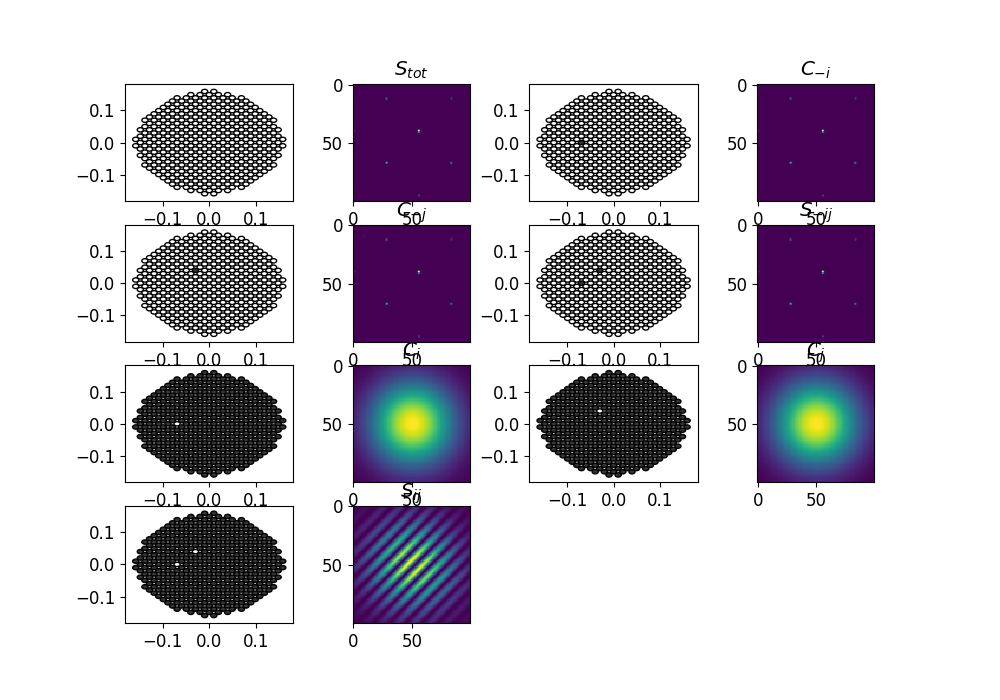

In [30]:
nn = 100
xmin = -0.06
xmax = 0.06
phi = np.arange(0.2, 0.4, 0.05)
theta = np.arange(0.2, 0.4, 0.05)
spectral_irradiance = 0.5
baseline = [161, 165]
nptg = len(theta)

power = get_power_on_array(q[0], nn, xmin, xmax, theta, phi, spectral_irradiance)

S_tot, Cminus_i, Cminus_j, Sminus_ij, Ci, Cj, Sij = selfcal_data(q[0], nn, xmin, xmax, theta, phi, spectral_irradiance,
                                                             baseline, doplot=True)


Let's compare:
- the franges obtained by one baseline $S_{ij}$
- the exact combination that gives the franges $S_{-ij} + C_i + C_j - C_{-i} - C_{-j} + S_{tot}$
- the combination with only the horn configurations we can acces experimentally $S_{-ij} - C_{-i} - C_{-j} + S_{tot}$.

In [1]:
figure()
subplot(2, 2, 1)
imshow(Sij[:, :, 0], interpolation='nearest', origin='lower')
colorbar()
title('True Baseline $S_{ij}$')

subplot(2, 2, 2)
imshow((S_tot + Ci + Cj - Cminus_i - Cminus_j + Sminus_ij)[:, :, 0], interpolation='nearest', origin='lower')
colorbar()
title('$S_{-ij} + C_i + C_j - C_{-i} - C_{-j} + S_{tot}$')

subplot(2, 2, 3)
imshow((S_tot - Cminus_i - Cminus_j + Sminus_ij)[:, :, 0], interpolation='nearest', origin='lower')
colorbar()
title('$S_{-ij} - C_{-i} - C_{-j} + S_{tot}$')



NameError: name 'Sij' is not defined